In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('/content/parkingLot (1).csv')
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%d-%m-%Y %H:%M', dayfirst=True, errors='coerce')

entry_data = data[data['camera_id'] == 1].copy()
exit_data = data[data['camera_id'] == 2].copy()

entry_data = entry_data.rename(columns={'timestamp': 'entry_time'})
exit_data = exit_data.rename(columns={'timestamp': 'exit_time'})

merged_data = pd.merge(entry_data, exit_data, on='vehicle_no', how='inner')
merged_data['time_spent'] = (merged_data['exit_time'] - merged_data['entry_time']).dt.total_seconds() / 60
merged_data = merged_data[(merged_data['time_spent'] > 0) & (merged_data['time_spent'] <= 24 * 60)]
merged_data['date'] = merged_data['entry_time'].dt.date
daily_avg_time = merged_data.groupby('date')['time_spent'].mean()

In [5]:
train_data, test_data = train_test_split(daily_avg_time, test_size=0.2, shuffle=False)

time_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 0, 7), enforce_stationarity=False, enforce_invertibility=False)
time_model_fit = time_model.fit(disp=False)
predictions = time_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
mae = mean_absolute_error(test_data, predictions)
naive_forecast = test_data.shift(1)
naive_mae = mean_absolute_error(test_data[1:], naive_forecast[1:])
mase = mae / naive_mae
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

print(f"MASE: {mase}")
print(f"MAPE: {mape}")

MASE: 9.376185044626592
MAPE: 66.5835341250523


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [6]:
time_model = SARIMAX(daily_avg_time, order=(1, 1, 1), seasonal_order=(1, 1, 0, 7), enforce_stationarity=False, enforce_invertibility=False)
time_model_fit = time_model.fit(disp=False)

future_forecast = time_model_fit.forecast(steps=7)
last_date = daily_avg_time.index[-1]
future_dates = pd.date_range(start=last_date, periods=7, freq='D')
forecast_series = pd.Series(future_forecast, index=future_dates)
print("Forecasted Average Time Spent in Minutes for the Next 7 Days:")
print(forecast_series)

Forecasted Average Time Spent in Minutes for the Next 7 Days:
2024-11-13           NaN
2024-11-14    322.927333
2024-11-15    324.381612
2024-11-16    299.406583
2024-11-17    336.037330
2024-11-18    353.502635
2024-11-19    372.477908
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


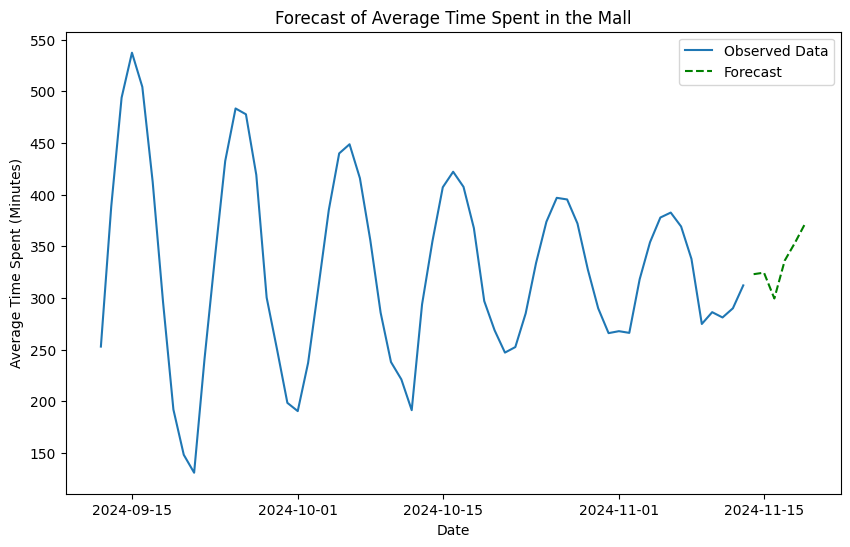

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(daily_avg_time.index, daily_avg_time, label='Observed Data')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (Minutes)')
plt.title('Forecast of Average Time Spent in the Mall')
plt.legend()
plt.show()
